In [1]:
%load_ext autoreload
%autoreload 2

In [61]:
import json

import numpy as np
import pandas as pd
from typing import Tuple
import matplotlib.pyplot as plt

#### Word2Vec
import gensim
from gensim.models import Word2Vec

####
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import torch.nn as nn
import torchutils as tu
from sklearn.model_selection import train_test_split
from collections import Counter
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

from torchmetrics.classification import BinaryAccuracy
from src.rnn_preprocessing import (
                                data_preprocessing, 
                                preprocess_single_string, 
                                padding, 
                                get_words_by_freq
                                )
from src.train_rnn import train_attention_lstm

In [62]:
# Лучше всего установить такую же версию
print(gensim.__version__)

4.3.2


In [63]:
# Укажите путь к вашему .jsonl файлу
file_path = '/home/savr/nlp_project/healthcare_facilities_reviews.jsonl'

# Чтение файла и загрузка данных в список
data = []
with open(file_path, 'r') as f:
    for line in f:
        data.append(json.loads(line))

# Преобразование списка словарей в DataFrame
df = pd.DataFrame(data)
reviews = df['content'].tolist()
preprocessed = [data_preprocessing(review) for review in reviews]

In [64]:
preprocessed[10]

'почему мы простые граждане должны быть в ответе за то что в данной поликлиники не было воды мало того что запись идет день в день с часов а по телефону ли по непонятной причине принять заявку тоже отказываются так еще и наплевательское отношение к людям в регистратуре легче всего видите ли отфудболить пациента на следующий день и никакого решения взамен какоето безразличие и непонимание проблем детей такие люди просто не должны находиться на данных местах так как это в первую очередь социальная ответственность тем более перед детьми'

In [65]:
# Анализируем частоты слов и выбираем только те, которые встречаются чаще порога
corpus = [word for text in preprocessed for word in text.split()]
sorted_words = Counter(corpus).most_common()
sorted_words = get_words_by_freq(sorted_words, 200)
sorted_words[-10:]

[('сотрудница', 201),
 ('прав', 201),
 ('методы', 201),
 ('спас', 201),
 ('внизу', 201),
 ('страшное', 201),
 ('письмо', 201),
 ('исследований', 201),
 ('младший', 201),
 ('беременные', 201)]

In [66]:
# Создаем словарь слово: индекс
vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}
# vocab_to_int

In [67]:
import json 
with open('vocab2int.json', 'w') as f:
    json.dump(vocab_to_int, f)

In [68]:
stop_words_txt = ','.join([str(i) for i in stop_words])
with open('stop_words.txt', 'w') as f:
    f.write(stop_words_txt)

In [69]:
list(vocab_to_int.items())[:10]

[('и', 1),
 ('в', 2),
 ('не', 3),
 ('на', 4),
 ('что', 5),
 ('я', 6),
 ('с', 7),
 ('к', 8),
 ('а', 9),
 ('у', 10)]

In [70]:
# Конвертируем слова в индексы
reviews_int = []
for text in preprocessed:
    r = [vocab_to_int[word] for word in text.split() if vocab_to_int.get(word)]
    reviews_int.append(r)
print([i for i in reviews_int[0]])
print(preprocessed[0])

[80, 20, 11, 850, 648, 389, 1231, 11, 98, 559, 7, 371, 874, 802, 613, 18, 12, 1006, 1, 6, 1758, 4, 850, 95, 1, 1145, 369, 58, 211, 1, 2132, 13, 349]
огромное спасибо за чудесное удаление двух зубов мудрости за мгновение доктор матвеев профессионал с большой буквы боялась страшно но все заняло реально секунд и я согласилась на удаление сразу и второго зуба без боли и страха очень рекомендую


In [71]:
w2v_input = []
for review in preprocessed:
    cur_review = []
    for word in review.split():
        if vocab_to_int.get(word):
            cur_review.append(word)
    w2v_input.append(cur_review)
print(f'Total reviews: {len(w2v_input)}')
print(f'Random review for word2vec: {w2v_input[np.random.randint(0, 50000)]}')

Total reviews: 70597
Random review for word2vec: ['я', 'лечилась', 'в', 'в', 'августе', 'того', 'года', 'мне', 'полностью', 'сделали', 'зубов', 'скажу', 'сразу', 'что', 'во', 'всех', 'остальных', 'клиниках', 'мне', 'ставить', 'коронки', 'и', 'даже', 'никто', 'не', 'хотел', 'мне', 'помочь', 'но', 'мне', 'очень', 'повезло', 'что', 'моим', 'доктором', 'оказалась', 'наталья', 'михайловна', 'врач', 'от', 'бога', 'специалист', 'я', 'до', 'сих', 'пор', 'хожу', 'к', 'ней', 'лечиться', 'и', 'очень', 'довольна', 'спасибо', 'ей', 'огромное', 'хожу', 'с', 'улыбкой', 'да', 'конечно', 'цены', 'в', 'данной', 'организации', 'не', 'самые', 'маленькие', 'но', 'мне', 'все', 'рано', 'обошлось', 'дешевле', 'чем', 'бы', 'мне', 'поставили', 'коронки', 'и', 'вообще', 'за', 'такую', 'работу', 'можно', 'заплатить', 'у', 'меня', 'с', 'работы', 'многие', 'девушки', 'обращались', 'с', 'наталье', 'михайловне', 'и', 'все', 'были', 'довольны', 'спасибо', 'вам']


In [72]:
VOCAB_SIZE = len(vocab_to_int) + 1  # размер словаря вместе с токеном padding
EMBEDDING_DIM = 64 # embedding_dim 

In [73]:
# Обучим Word2Vec
wv = Word2Vec(
    vector_size=EMBEDDING_DIM # размерность вектора для слова
    )
# Сначала word2vec составляет словарь
wv.build_vocab(w2v_input)
print(f'Total reviews: {wv.corpus_count}')

Total reviews: 70597


In [74]:
# Далее обучаем
wv.train(
    corpus_iterable=w2v_input, 
    total_examples=wv.corpus_count, 
    epochs=10
    )

(39359172, 50573400)

In [75]:
# Создаем слой эмбеддинга
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))

# Бежим по всем словам словаря: если слово есть в word2vec, 
# достаем его вектор; если слова нет, то распечатываем его и пропускаем
for word, i in vocab_to_int.items():
    try:
        embedding_vector = wv.wv[word]
        embedding_matrix[i] = embedding_vector
    except KeyError as e:
        pass
        print(f'{e}: word: {word}')
        
# Создаем предобученный эмбеддинг – этот слой в нашей сети обучаться не будет
embedding_layer = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix))
print(f'Number of words x EMEDDING_DIM: {embedding_matrix.shape}')

Number of words x EMEDDING_DIM: (3305, 64)


In [76]:
# Применяем padding
padded = padding(review_int=reviews_int, seq_len=64)
print(padded[5])

[ 127   20 2025 2600    6   13  409  422  968   61    7  371  874  311
 1116   93  190 1259 2487  369    2  154   14   23 2710    2  164  661
  317    6  358    1   14   17    3 1981 2025 2600   32  260    2  184
   12 1267  397   85   32  895    1   58  187  280  247  278  380  206
    1    2   90 3234  876 1637 2875   12]


In [77]:
# train_test split + label encoding 
X_train, X_valid, y_train, y_valid = train_test_split(
    np.array(padded),
    pd.get_dummies(
        df['sentiment'], 
        drop_first=True
    ).values.astype('int'), test_size=0.2, random_state=1)

In [78]:
BATCH_SIZE = 64

train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(X_valid), torch.from_numpy(y_valid))
train_loader = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=BATCH_SIZE)

In [79]:
# посмотрим, что внутри
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)

print('Sample input size: BATCH_SIZE x SEQ_LEN', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y[:10])

Sample input size: BATCH_SIZE x SEQ_LEN torch.Size([64, 64])
Sample input: 
 tensor([[   0,    0,    0,  ...,  127,   31,   20],
        [   6,   44, 2593,  ...,   14, 1044,  308],
        [  76, 1573,  407,  ...,    6,    2, 1740],
        ...,
        [   0,    0,    0,  ..., 2547,   14,   13],
        [ 124,    2,  164,  ...,    1, 3268,    6],
        [   0,    0,    0,  ...,  294,   20,   31]])
Sample input: 
 tensor([[1],
        [0],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1]])


In [21]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [80]:
HIDDEN_SIZE = 32

In [81]:
class ConcatAttention(nn.Module):
    def __init__(
            self, 
            hidden_size: int = HIDDEN_SIZE
            ) -> None:
        
        super().__init__()
        self.hidden_size = hidden_size
        self.linear = nn.Linear(self.hidden_size, self.hidden_size)
        self.align  = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.tanh   = nn.Tanh()

    def forward(
            self, 
            lstm_outputs: torch.Tensor, # BATCH_SIZE x SEQ_LEN x HIDDEN_SIZE
            final_hidden: torch.Tensor  # BATCH_SIZE x HIDDEN_SIZE
            ) -> Tuple[torch.Tensor, torch.Tensor]:
        
        att_weights = self.linear(lstm_outputs)
        # print(f'After linear: {att_weights.shape, final_hidden.unsqueeze(2).shape}')
        att_weights = torch.bmm(att_weights, final_hidden.unsqueeze(2))
        # print(f'After bmm: {att_weights.shape}')
        att_weights = F.softmax(att_weights.squeeze(2), dim=1)
        # print(f'After softmax: {att_weights.shape}')
        cntxt       = torch.bmm(lstm_outputs.transpose(1, 2), att_weights.unsqueeze(2))
        # print(f'Context: {cntxt.shape}')
        concatted   = torch.cat((cntxt, final_hidden.unsqueeze(2)), dim=1)
        # print(f'Concatted: {concatted.shape}')
        att_hidden  = self.tanh(self.align(concatted.squeeze(-1)))
        # print(f'Att Hidden: {att_hidden.shape}')
        return att_hidden, att_weights

# Test on random numbers
ConcatAttention()(torch.randn(BATCH_SIZE, 128, HIDDEN_SIZE), torch.randn(BATCH_SIZE, HIDDEN_SIZE))[1].shape

torch.Size([64, 128])

In [82]:
attention = ConcatAttention(HIDDEN_SIZE)

In [83]:
tu.get_model_summary(attention, torch.randn(16, 32, HIDDEN_SIZE), torch.randn(16, HIDDEN_SIZE))

Layer       Kernel       Output      Params       FLOPs
0_linear   [32, 32]   [16, 32, 32]    1,056   1,032,192
1_align    [64, 32]       [16, 32]    2,080      65,024
2_tanh            -       [16, 32]        0       2,560
Total params: 3,136
Trainable params: 3,136
Non-trainable params: 0
Total FLOPs: 1,099,776 / 1.10 MFLOPs
-------------------------------------------------------
Input size (MB): 0.06
Forward/backward pass size (MB): 0.13
Params size (MB): 0.01
Estimated Total Size (MB): 0.21


In [84]:
SEQ_LEN = 32

In [85]:
class LSTMConcatAttention(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        # self.embedding = nn.Embedding(VOCAB_SIZE, EMBEDDING_DIM)
        self.embedding = embedding_layer
        self.lstm = nn.LSTM(EMBEDDING_DIM, HIDDEN_SIZE, batch_first=True)
        self.attn = ConcatAttention(HIDDEN_SIZE)
        self.clf = nn.Sequential(
            nn.Linear(HIDDEN_SIZE, 128),
            nn.Dropout(),
            nn.Tanh(),
            nn.Linear(128, 1)
        )
    
    def forward(self, x):
        embeddings = self.embedding(x)
        outputs, (h_n, _) = self.lstm(embeddings)
        att_hidden, att_weights = self.attn(outputs, h_n.squeeze(0))
        out = self.clf(att_hidden)
        return out, att_weights

In [86]:
model_concat = LSTMConcatAttention()
DEVICE='cuda'
criterion = nn.BCEWithLogitsLoss()
optimizer_concat = torch.optim.RMSprop(model_concat.parameters(), lr=0.001)

metric = BinaryAccuracy() #BinaryAccuracy().to(device)

In [30]:
train_losses, val_losses, train_metric, val_metric, rnn_time = train_attention_lstm(
    10, model_concat, train_loader, valid_loader, optimizer_concat, criterion, metric
)

Epoch 1
train_loss : 0.2429 val_loss : 0.2355
train_accuracy : 0.90 val_accuracy : 0.91
Epoch 2
train_loss : 0.2060 val_loss : 0.2221
train_accuracy : 0.92 val_accuracy : 0.92
Epoch 3
train_loss : 0.1895 val_loss : 0.2417
train_accuracy : 0.93 val_accuracy : 0.91
Epoch 4
train_loss : 0.1775 val_loss : 0.2205
train_accuracy : 0.93 val_accuracy : 0.92
Epoch 5
train_loss : 0.1662 val_loss : 0.2133
train_accuracy : 0.94 val_accuracy : 0.92
Epoch 6
train_loss : 0.1566 val_loss : 0.2505
train_accuracy : 0.94 val_accuracy : 0.91
Epoch 7
train_loss : 0.1481 val_loss : 0.2182
train_accuracy : 0.95 val_accuracy : 0.92
Epoch 8
train_loss : 0.1401 val_loss : 0.2377
train_accuracy : 0.95 val_accuracy : 0.92
Epoch 9
train_loss : 0.1314 val_loss : 0.2446
train_accuracy : 0.95 val_accuracy : 0.92
Epoch 10
train_loss : 0.1239 val_loss : 0.2513
train_accuracy : 0.96 val_accuracy : 0.92


In [87]:
vocab_to_int['<pad>'] = 0

In [88]:
int_to_vocab = {j:i for i, j in vocab_to_int.items()}

In [89]:
def plot_and_predict(review: str, SEQ_LEN: int, model: nn.Module):
    """Predict class and draw word attention scores 

    Args:
        review (str): Review text
        SEQ_LEN (int): sequence length
        model (nn.Module): trained model
    """
    preprocessed = data_preprocessing(review) # preprocess string
    inp = preprocess_single_string(review, SEQ_LEN, vocab_to_int)
    model.eval()
    with torch.inference_mode():
        pred, att_scores = model(inp.long().unsqueeze(0))
    plt.figure(figsize=(12, 4))
    print(f'Prepocessed string: {preprocessed}')
    print(f'Prediction {pred.sigmoid().item():.3f}')
    print(max(att_scores.detach().cpu().numpy()[0]))
    plt.bar(np.arange(len(inp)), att_scores.detach().cpu().numpy()[0])
    plt.ylim(0, max(att_scores.detach().cpu().numpy()[0])+.2)
    plt.xticks(
        ticks = np.arange(len(inp)), 
        labels = [int_to_vocab[x.item()] for x in inp]
        );
    score_label_shift = len(inp)*.02
    for x, y in zip(np.arange(len(inp)), att_scores.detach().cpu().numpy()[0]):
        plt.text(x-score_label_shift, y+.005, s=f'{y:.2f}')


Prepocessed string: лучшая клиника в которой я был
Prediction 1.000
0.42073405


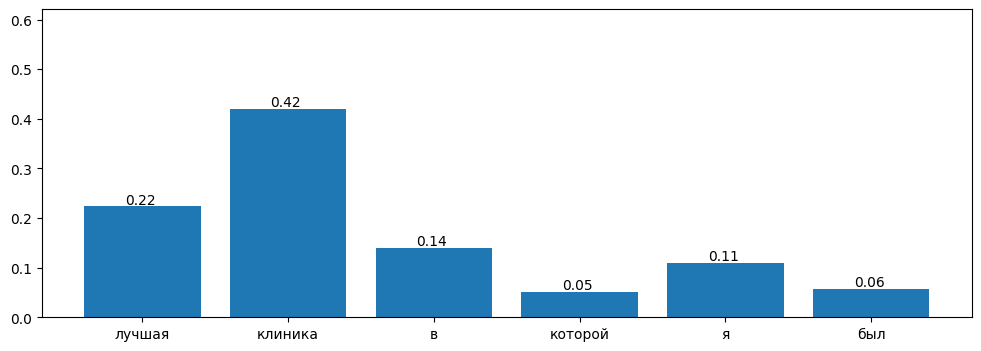

In [36]:
review = "Лучшая клиника в которой я был"
plot_and_predict(
    review = review, 
    SEQ_LEN=len(review.split()),
    model = model_concat
)

In [40]:
torch.save(model_concat.state_dict(), 'lstm_attention_weights.pt')

In [91]:
with torch.inference_mode():
    out = model_concat(preprocessed.unsqueeze(0))

AttributeError: 'list' object has no attribute 'unsqueeze'